In [146]:
!pip install --upgrade pandas tqdm openpyxl geopandas matplotlib

Requirement already up-to-date: pandas in ./venv/lib/python3.8/site-packages (1.3.1)
Requirement already up-to-date: tqdm in ./venv/lib/python3.8/site-packages (4.62.0)
Requirement already up-to-date: openpyxl in ./venv/lib/python3.8/site-packages (3.0.7)
Requirement already up-to-date: geopandas in ./venv/lib/python3.8/site-packages (0.9.0)
     |████████████████████████████████| 10.3 MB 7.1 MB/s 
     |████████████████████████████████| 3.0 MB 83.5 MB/s 
     |████████████████████████████████| 1.2 MB 70.2 MB/s 


In [165]:
import os
import urllib.parse
from tqdm.notebook import tqdm

In [166]:
# copypasta from tqdm docs
class TqdmUpTo(tqdm):
    """Provides `update_to(n)` which uses `tqdm.update(delta_n)`."""
    def update_to(self, b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            self.total = tsize
        return self.update(b * bsize - self.n)  # also sets self.n = b * bsize

In [167]:
RESULTS_URL="https://www.sos.wa.gov/_assets/elections/research/2020Gen_Precinct_Results_GIS-Ready.xlsx"
# https://stackoverflow.com/questions/39125532/file-does-not-exist-in-jupyter-notebook
# https://kingcounty.gov/depts/elections/elections/maps/precinct-and-district-data.aspx
PRECINCTS_URL='https://kingcounty.gov/~/media/depts/elections/elections/maps/precinct-and-district-data.ashx?la=en'
# https://kingcounty.maps.arcgis.com/home/item.html?id=05d243e41a134f9689a78331b86a66e1
DISTRICT_SHAPE_URL="https://aqua.kingcounty.gov/gis/web/GISData/district_SHP.zip"

OUT_FILENAME='results_in_seattle.csv'


In [168]:
import urllib.request

def download(url):
  basename = os.path.basename(urllib.parse.urlparse(url).path)
  req = urllib.request.Request(
      url, 
      data=None, 
      headers={
          'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
      }
  )
  # copypasta from tqdm docs
  if not os.path.exists(basename):
    with urllib.request.urlopen(req) as response:
      with tqdm.wrapattr(open(basename, "wb"), "write",
                        miniters=1, desc=basename,
                        total=getattr(response, 'length', None)) as fout:
        for chunk in response:
            fout.write(chunk)
  return basename

In [169]:
results_excel = download(RESULTS_URL)
precincts_excel = download(PRECINCTS_URL)
district_shapes_zip = download(DISTRICT_SHAPE_URL)

In [170]:
import pandas as pd

# this one can take a little while (~2min on colab)
with open(results_excel, 'rb') as f:
  results = pd.read_excel(f)

In [ ]:

# this should be prety quick
with open(precincts_excel, 'rb') as f:
  precincts = pd.read_excel(f)


In [ ]:
import zipfile

citydst_shp = None
with zipfile.ZipFile(district_shapes_zip, 'r') as z:
  for info in z.infolist():
    if 'citydst.shp' == os.path.basename(info.filename):
      citydst_shp = z.extract(info)
    elif 'citydst' in os.path.basename(info.filename):
      z.extract(info)

if not citydst_shp:
  print(f"ERORR:'citydst.shp' not found in '{info.filename}'")

citydst_shp


'/home/mdegans/Projects/seattle_election/districtSHP/citydst.shp'

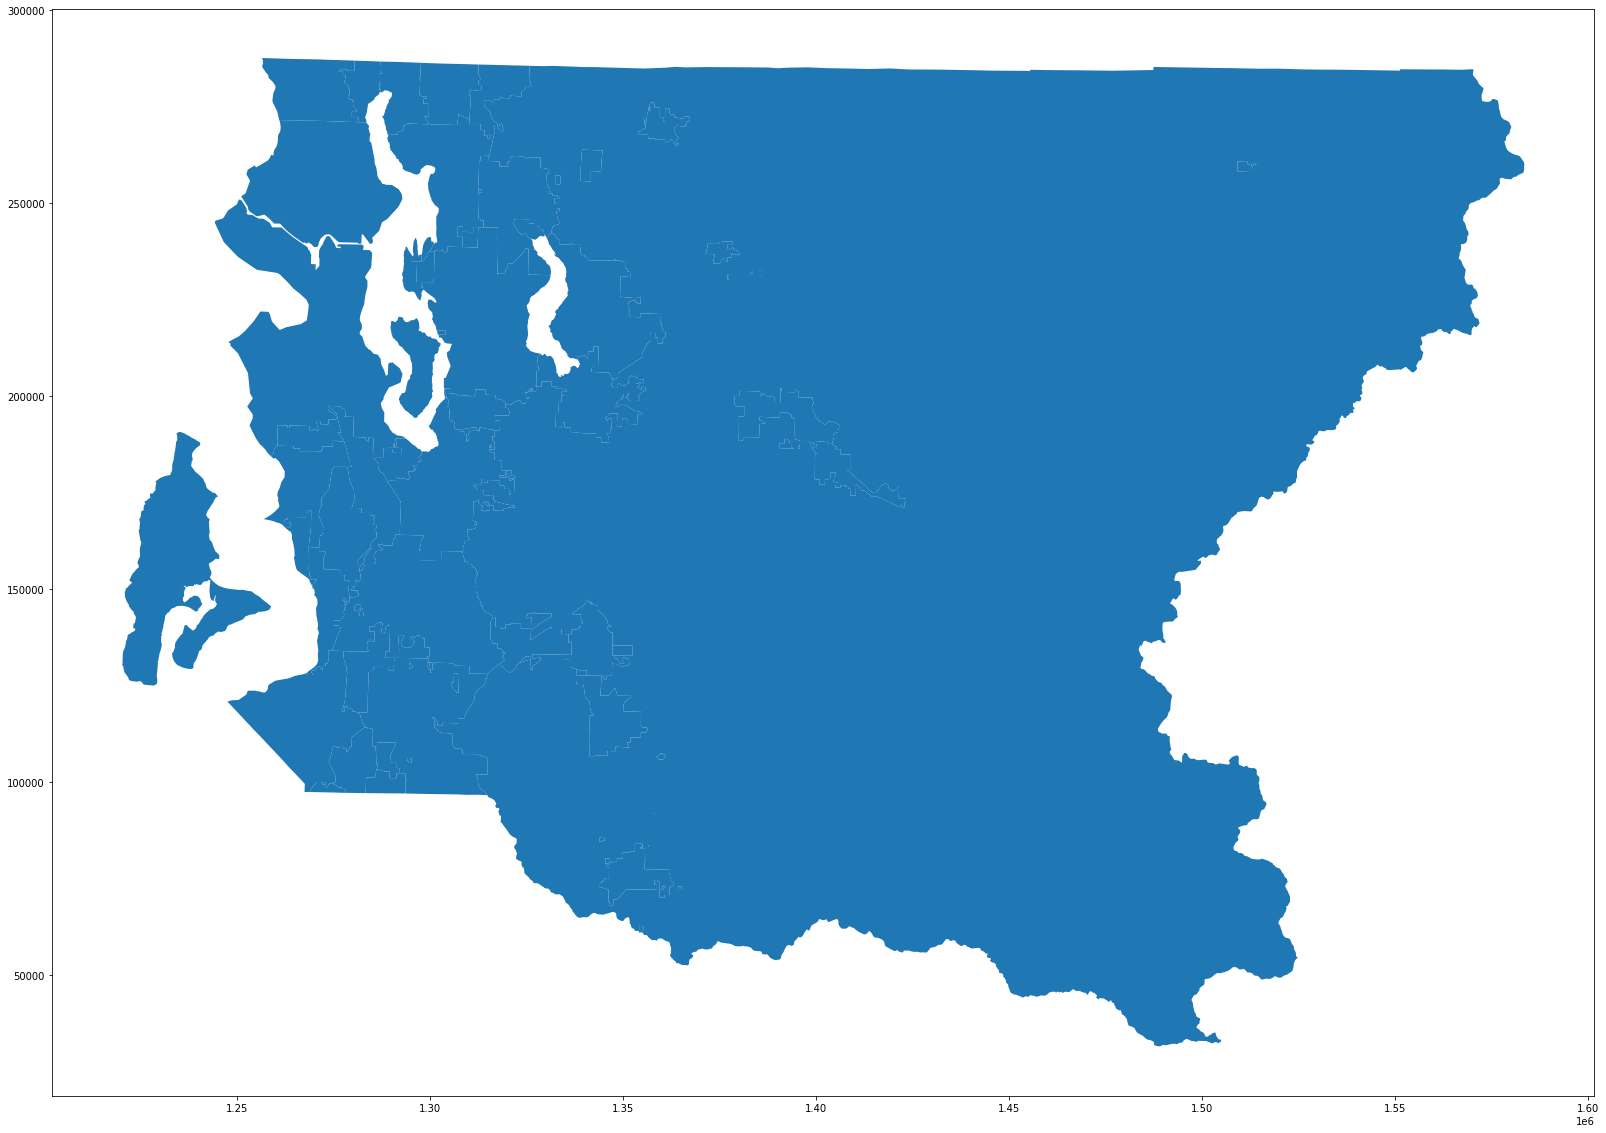

In [159]:
import geopandas as gpd
import matplotlib.pyplot as plt

# https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55
district_shapes = gpd.read_file(citydst_shp)
district_shapes.plot(figsize=(40,20))
plt.show()

In [160]:
# just king country results
results = results[results.County == 'King']
# unique district names
results['DistrictName'].unique()


array(['Turnout', 'State of Washington', 'United States',
       'Congressional District 7', 'Legislative District 32',
       'Supreme Court', 'Court of Appeals, Division 1, District 1',
       'King Superior Court', 'Legislative District 46',
       'Legislative District 33', 'Congressional District 1',
       'Legislative District 45', 'Congressional District 9',
       'Legislative District 41', 'Congressional District 8',
       'Legislative District 30', 'Legislative District 1',
       'Legislative District 37', 'Legislative District 34',
       'Legislative District 47', 'Legislative District 11',
       'Legislative District 5', 'Legislative District 31',
       'Legislative District 48', 'Legislative District 39',
       'Legislative District 43', 'Legislative District 36'], dtype=object)

In [161]:
# just seattle precincts
precincts = precincts[precincts.SeattleCouncilDistrict.notnull()]
precincts

PrecinctCode PrecinctName  CountyCouncil  LegislativeDistrict  \
761           1245  SEA 34-1245              8                   34   
762           1246  SEA 34-1246              8                   34   
763           1247  SEA 34-1247              8                   34   
764           1248  SEA 34-1248              8                   34   
765           1249  SEA 34-1249              8                   34   
...            ...          ...            ...                  ...   
2741          3948  SEA 37-3948              2                   37   
2742          3949  SEA 43-3949              2                   43   
2743          3950  SEA 43-3950              2                   43   
2744          3951  SEA 43-3951              4                   43   
2745          3952  SEA 43-3952              1                   43   

      CongressionalDistrict  SeattleCouncilDistrict  
761                       7                     1.0  
762                       7                     1.0  
763                       7                     1.0  
764                       7                     1.0  
765                       7                     1.0  
...                     ...                     ...  
2741                      9                     2.0  
2742                      7                     3.0  
2743                      7                     4.0  
2744                      7                     4.0  
2745                      7                     4.0  

[1020 rows x 6 columns]

In [162]:
# unique precinct names
seattle_precincts = precincts['PrecinctName'].unique()
seattle_precincts

array(['SEA 34-1245', 'SEA 34-1246', 'SEA 34-1247', ..., 'SEA 43-3950',
       'SEA 43-3951', 'SEA 43-3952'], dtype=object)

In [163]:
results_in_seattle = results[results.PrecinctName.isin(seattle_precincts)]
results_in_seattle

DistrictName                   RaceName  SeqNo  \
156417              Turnout                    Turnout      0   
156418              Turnout                    Turnout      0   
156419  State of Washington  Referendum Measure No. 90    200   
156420  State of Washington  Referendum Measure No. 90    200   
156421  State of Washington       Advisory Vote No. 32    632   
...                     ...                        ...    ...   
301080  King Superior Court          Judge Position 13  11713   
301081  King Superior Court          Judge Position 13  11713   
301082  King Superior Court          Judge Position 30  11730   
301083  King Superior Court          Judge Position 30  11730   
301084  King Superior Court          Judge Position 30  11730   

                Candidate  BallotOrder PrecinctCode PrecinctName County  \
156417  Registered Voters            1   KI00001245  SEA 34-1245   King   
156418       Ballots Cast            2   KI00001245  SEA 34-1245   King   
156419           Approved            1   KI00001245  SEA 34-1245   King   
156420           Rejected            2   KI00001245  SEA 34-1245   King   
156421           Repealed            1   KI00001245  SEA 34-1245   King   
...                   ...          ...          ...          ...    ...   
301080   Andrea Robertson            2   KI00003840  SEA 37-3840   King   
301081           WRITE-IN            3   KI00003840  SEA 37-3840   King   
301082         Doug North            1   KI00003840  SEA 37-3840   King   
301083       Carolyn Ladd            2   KI00003840  SEA 37-3840   King   
301084           WRITE-IN            3   KI00003840  SEA 37-3840   King   

          CandCode Votes  
156417  G20TREGVOT   571  
156418  G20TBALCST   500  
156419   G20R0090A   386  
156420   G20R0090R    85  
156421   G20A0032R   184  
...            ...   ...  
301080  G20KI13ROB   160  
301081  G20KI13W00     4  
301082  G20KI30NOR   161  
301083  G20KI30LAD   204  
301084  G20KI30W00     1  

[76475 rows x 10 columns]

In [164]:
with open(OUT_FILENAME, 'wb') as f:
  results_in_seattle.to_csv(f)